# Rasterizing vectors & vectorizing rasters <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_annual_summary](https://explorer.sandbox.dea.ga.gov.au/wofs_annual_summary)

## Background

Many remote sensing and/or geospatial workflows require converting between vector data (e.g. shapefiles) and raster data (e.g. pixel-based data like that in an `xarray.DataArray`).
For example, we may need to use a shapefile as a mask to limit the analysis extent of a raster, or have raster data that we want to convert into vector data to allow for easy geometry operations.

## Description
This notebook demonstrates the use of the python package [rasterio](https://rasterio.readthedocs.io/en/stable/index.html) to convert between raster and vector data.  

The first section loads in [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) data from Digital Earth Australia, and vectorises the pixel-based `xarray.DataArray` object into a vector-based `geopandas.GeoDataFrame` object containing persistent water-bodies as polygons. 
We then export the `GeoDataframe` as a shapefile.  

The second section rasterises the vector data we created in the first section back into an `xarray.DataArray`, and exports the results as a GeoTIFF.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import pprint
import shapely
import rasterio.features
import numpy as np
import xarray as xr
import geopandas as gpd
from datacube.helpers import write_geotiff


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Rasterize_vectorize')

## Load WOfS data from the datacube

We will load in an annual summary from the [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product to provide us with some data to work with. The query below will load the 2000 annual summary of WOfS for the region around the Menindee Lakes.

In [3]:
# Create a query object
query = {
    'x': (142.1, 142.80),
    'y': (-32.1, -32.6),
    'time': ('2000')
}

# Load WoFS through the datacube
ds = dc.load(product='wofs_annual_summary', 
             **query)

print(ds)


<xarray.Dataset>
Dimensions:      (time: 1, x: 2789, y: 2443)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01
  * y            (y) float64 -3.536e+06 -3.536e+06 ... -3.597e+06 -3.597e+06
  * x            (x) float64 9.396e+05 9.396e+05 ... 1.009e+06 1.009e+06
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 24 24 23 23 23 24 24 ... 12 12 12 12 12 12
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG:3577


### Plot the WOfS summary

Let's plot the WOfS data to get an idea of the objects we will be transforming. 
In the code below, we first select the pixels where the satellite has observed water at least 25% of the year, this is so we can isolate the more persistent water bodies and reduce some of the noise before we vectorize the raster.

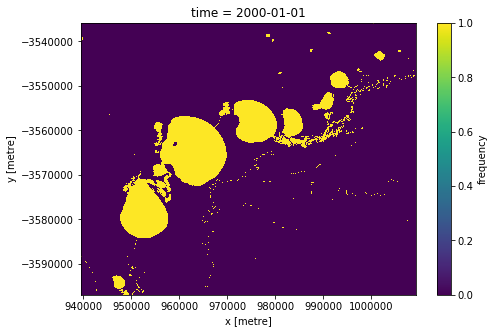

In [4]:
# Select pixels that are classified as water > 25 % of the time
water_bodies = ds.frequency > 0.25

# Plot the data
water_bodies.plot(size=5)

## Vectorizing an `xarray.DataArray`

Using [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html), we will turn our `xarray.DataArray` of the persistent water bodies into a shapefile:

* The `source` parameter requires a simple `numpy` array, with the datatype explicitly set. 
* We can use the `mask` parameter to set which values in the array we want to convert to vectors. 
In this instance, we want to convert only the values of 1, which correspond to the persistent water bodies in the array. 
* The `transform` parameter provides the geospatial coordinates to transform the array into a geo-located shapefile. 
We can get this from our original `xarray.Dataset`.

In [5]:
# First grab the spatial information from our datacube xarray object
transform = ds.geobox.transform

# Run the vectorizing function
vectors = rasterio.features.shapes(source=water_bodies.data.astype('int16'),
                                   mask=(water_bodies.data == 1),
                                   transform=transform)


The returned object is a `generator` that contains the `(polygon, value)` pair for each unique feature in the array. 
Before we can create a shapefile, we can unpack the generator objects into lists which are easier to manipulate.

The last part of the code will print the first `(polygon, value)` pair to show what these objects look like.

In [6]:
# First convert the genertor into a list, as a generator can only be consumed once
vectors = list(vectors)

# Extract the polygon coordinates and values from the list using list comprehension
polygons = [polygon for polygon, value in vectors]
values = [value for polygon, value in vectors]

print('Image value: ' + str(values[0]))
print('Geometry:')
pprint.pprint(polygons[0])


Image value: 1.0
Geometry:
{'coordinates': [[(943150.0, -3535850.0),
                  (943150.0, -3535875.0),
                  (943125.0, -3535875.0),
                  (943125.0, -3535925.0),
                  (943175.0, -3535925.0),
                  (943175.0, -3535900.0),
                  (943200.0, -3535900.0),
                  (943200.0, -3535850.0),
                  (943150.0, -3535850.0)]],
 'type': 'Polygon'}


Now that we have a list of geometries and values, we can add these to a [geopandas.GeoDataFrame](http://geopandas.org/). 
`geopandas` is a very useful library for handling vector data as it extends `pandas` to allow spatial operations.

Before we create the `geopandas.GeoDataFrame`, we need to convert the polygon coordinates we extracted above into spatial `shapely.geometry` polygon shape features.
This is required in order for `geopandas` to be able to be used for spatial analyses.

In [7]:
# First we need to convert our polygon coordinates into polygon shapes
polygons = [shapely.geometry.shape(polygon) for polygon in polygons]

# Create a geopandas dataframe populated with the polygon shapes
gdf = gpd.GeoDataFrame(data={'attributes': values},
                       geometry=polygons,
                       crs=str(ds.crs))


### Plot our vectorised raster 

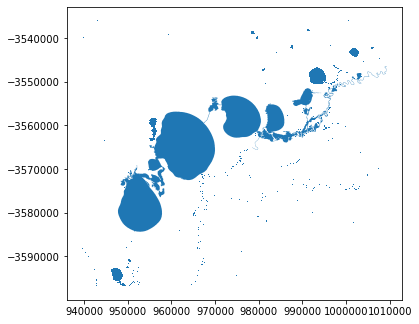

In [8]:
gdf.plot(figsize=(6, 6))

### Export as shapefile

`geopandas` allows us to very easily export the `GeoDataFrame` as a shapefile for use in other applications.

In [9]:
gdf.to_file('water_bodies.shp')

## Rasterizing a shapefile

Using [rasterio.features.rasterize](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) we can turn the `geopandas.GeoDataFrame` back into a `xarray.Dataset`. 
As we already have the `GeoDataFrame` loaded we don't need to read in the shapefile, but if we wanted to read in a shapefile first we can use [gpd.read_file()](http://geopandas.org/reference/geopandas.read_file.html).   

The first step is to extract an iterable of `(geometry, value)` pairs from the `gdf` object:

In [10]:
# Use the geometry and attributes from `gdf` to create an iterable
# zip of `(geometry, value)` pairs
shapes = zip(gdf['geometry'], gdf['attributes'])


We can now use the `(geometry, value)` iterable `shapes` to rasterize the polygons using `rasterio.features.rasterize`.  
We also need to extract a `transform` object and the `x, y` length of the output array; this information we can grab from the intial WOfS dataset.

In [11]:
# First grab the spatial information from our datacube xarray object
transform = ds.geobox.transform
y, x = ds.frequency.squeeze().values.shape

# Now convert the polgons into a numpy array
water_bodies_again = rasterio.features.rasterize(shapes=shapes,
                                                 out_shape=(y, x),
                                                 all_touched=False,
                                                 fill=np.nan,
                                                 transform=transform)


Finally, we can convert our array back into an `xarray.Dataset` object for plotting and exporting as a GeoTIFF.

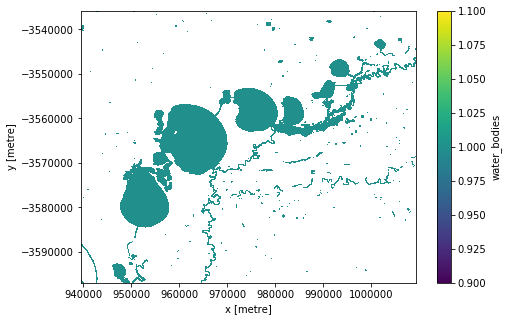

In [12]:
# Convert result to a xarray.DataArray using coords etc from original dc.load dataset
water_bodies_again = xr.DataArray(water_bodies_again,
                                  coords=[ds.y, ds.x],
                                  dims=['y', 'x'],
                                  name='water_bodies',
                                  attrs=ds.attrs)

# Convert to xarray dataset to assist with writing to GeoTIFF
water_bodies_again = water_bodies_again.to_dataset()
water_bodies_again.attrs = ds.attrs

# Plot the result
water_bodies_again.water_bodies.plot(size=5)


### Export as GeoTIFF

The final step is to export the raster as a GeoTIFF.
To learn more about this process, see the [Exporting GeoTIFFs](./Exporting_GeoTIFFs.ipynb) notebook.

In [13]:
write_geotiff('water_bodies_again.tif', water_bodies_again)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)